In [1]:
#!pip install yfinance
#!pip install hmmlearn
#pip install scipy
#pip install --upgrade --user hmmlearn
#pip install --user git+https://github.com/hmmlearn/hmmlearn
from sklearn.mixture import GaussianMixture
import yfinance as yf
import numpy as np
from numpy import random
import pandas as pd
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM 
import matplotlib.pyplot as plt

In [71]:
#add years on x axis for predicted v real close prices (& HAR)

# Data collection

In [52]:
ticker = "^GSPC"  #S&P 500 index symbol
daily = yf.download(ticker, start="1950-03-01", end="2016-11-30", interval="1d")
#data.loc[(data['Open'] == 0) & (data.index >= '1961-12-29') & (data.index <= '1982-04-20'), 'Open'] = np.nan
#Before 29th Dec 1961, same values in the row
#Between 29th Dec 1961 and 20th April 1982, "Open" set to 0

daily = daily[daily.columns[0:4]]

[*********************100%%**********************]  1 of 1 completed


In [54]:
# Resample the data to monthly frequency
monthly = daily.resample('MS').agg({'Open': 'first','High': 'max','Low': 'min','Close': 'last'})
#monthly.loc[(monthly['Open'] == 0) & (monthly.index >= '1961-12-29') & (monthly.index <= '1982-04-20'), 'Open'] = np.nan

# Reset the index to have 'Date' as a column
monthly = monthly.reset_index()
monthly = monthly.dropna()

# Descriptive statistics

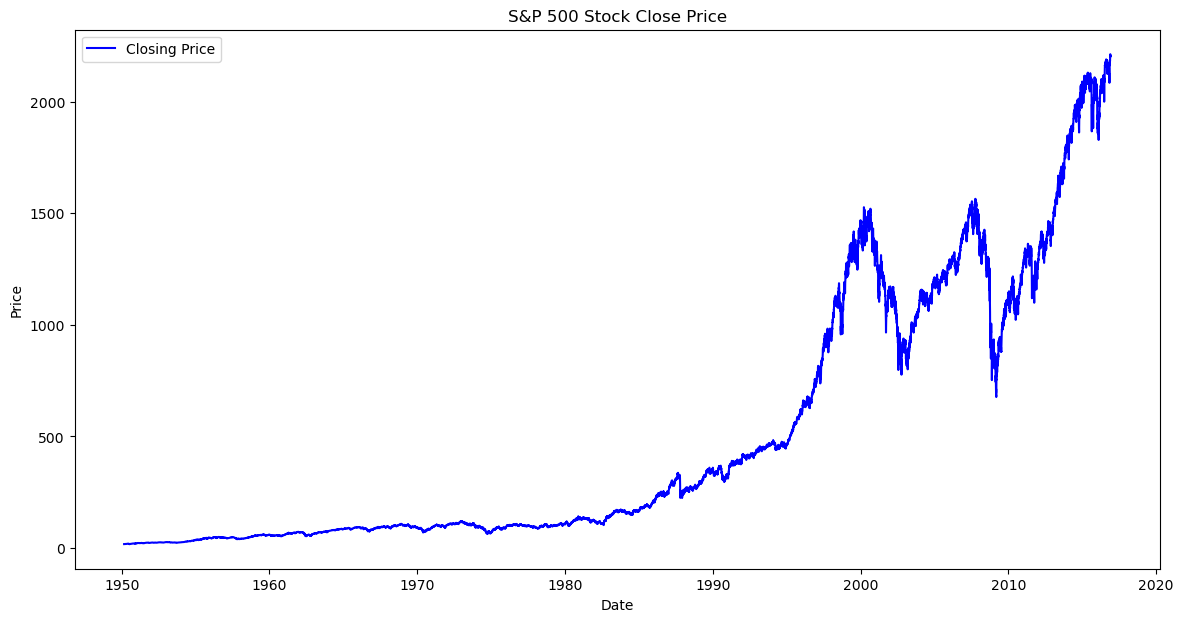

In [57]:
plt.figure(figsize=(14, 7))
plt.plot(daily.index, daily['Close'], label='Closing Price', color='blue')
plt.title('S&P 500 Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [59]:
descriptive_stats = {
    "Price": ["Open", "High", "Low", "Close"],
    "Min": [monthly['Open'].min(), monthly['High'].min(), monthly['Low'].min(), monthly['Close'].min()],
    "Max": [monthly['Open'].max(), monthly['High'].max(), monthly['Low'].max(), monthly['Close'].max()],
    "Mean": [monthly['Open'].mean(), monthly['High'].mean(), monthly['Low'].mean(), monthly['Close'].mean()],
    "Std.": [monthly['Open'].std(), monthly['High'].std(), monthly['Low'].std(), monthly['Close'].std()],
}

summary_table = pd.DataFrame(descriptive_stats)
summary_table = summary_table.round(2)
summary_table.to_csv('summary_table.csv', index=False, sep=';')
summary_table

,Price,Min,Max,Mean,Std.
0,Open,0.00,2173.15,476.55,603.86
1,High,17.56,2213.35,521.74,599.50
2,Low,16.68,2147.58,488.09,563.17
3,Close,17.29,2204.66,507.94,585.17


# Model Selection

In [61]:
#Method 1 : visual choice
monthly = monthly.dropna()

sample = monthly[561:801] #1996-12-01 to 2016-01-01
sample = sample[sample.columns[1:5]]
monthly = monthly[monthly.columns[1:5]]

# Set the number of observations to consider for each iteration
T = 120

AIC, BIC, HQC, CAIC = [], [], [], []

# Iterate over different number of components for the HMM model
for n in range(2, 7):
    np.random.seed(42)
    # Initialize empty lists to store the evaluation criteria values for each iteration
    a, b, c, d = [], [], [], []

    # Flag to check if it is the first iteration
    first_time = True

    # Iterate over the data with a sliding window of size T
    for i in range(0, T):
        # Define the HMM model
        if first_time:
            # For the first iteration, create a new model
            model = GaussianHMM(n_components=n, n_iter=T)
            first_time = False
        else:
            # For subsequent iterations, create a new model and initialize its parameters
            old_model = model
            model = GaussianHMM(n_components=n, init_params="c", n_iter=T)
            model.startprob_ = old_model.startprob_
            model.transmat_ = old_model.transmat_
            model.means_ = old_model.means_

        # Train the model using the Baum-Welch algorithm
        model.fit(sample[i:i+T])

        # Perform the forward algorithm to compute log-likelihoods and forward probabilities
        log_likelihoods, fwd = model.score_samples(sample[i:i+T])

        # Calculate the number of parameters for the model
        k = n**2 + 2*n - 1

        # Calculate AIC (Akaike Information Criterion)
        aic = -2 * log_likelihoods + 2 * k

        # Calculate BIC (Bayesian Information Criterion)
        bic = -2 * log_likelihoods + k * np.log(4 * T)

        # Calculate HQC (Hannan-Quinn Criterion)
        hqc = -2 * log_likelihoods + k * (np.log(np.log(4 * T)))

        # Calculate CAIC (Consistent Akaike Information Criterion)
        caic = -2 * log_likelihoods + k * (np.log(4 * T) + 1)

        # Append the evaluation criteria values to the corresponding lists
        a.append(aic)
        b.append(bic)
        c.append(hqc)
        d.append(caic)

    # Append the evaluation criteria lists for the current number of components to the main lists
    AIC.append(a)
    BIC.append(b)
    HQC.append(c)
    CAIC.append(d)

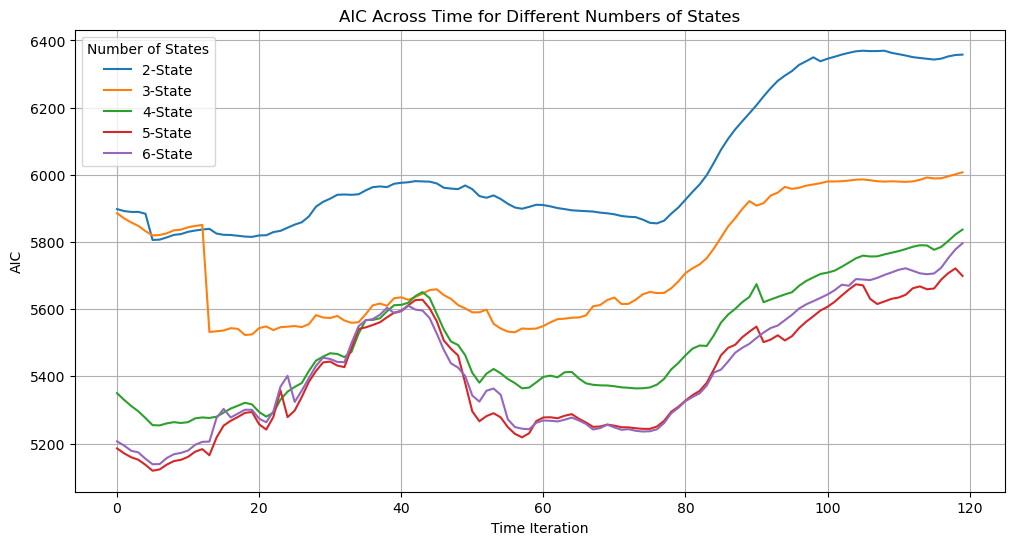

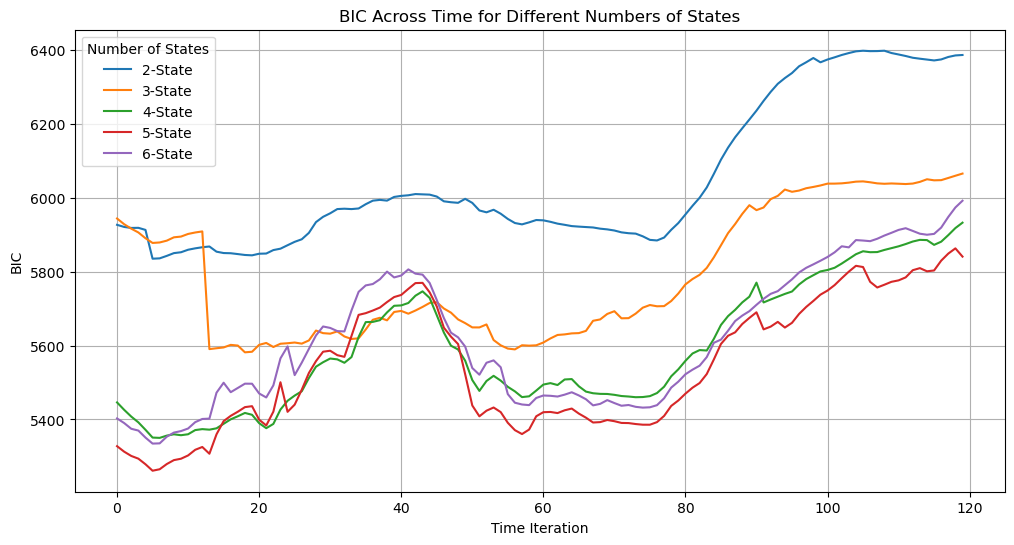

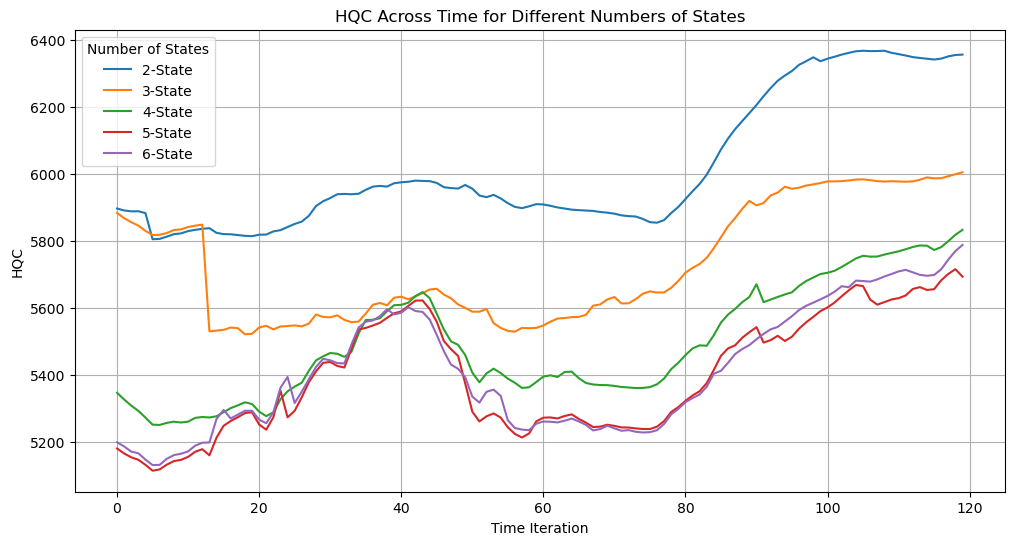

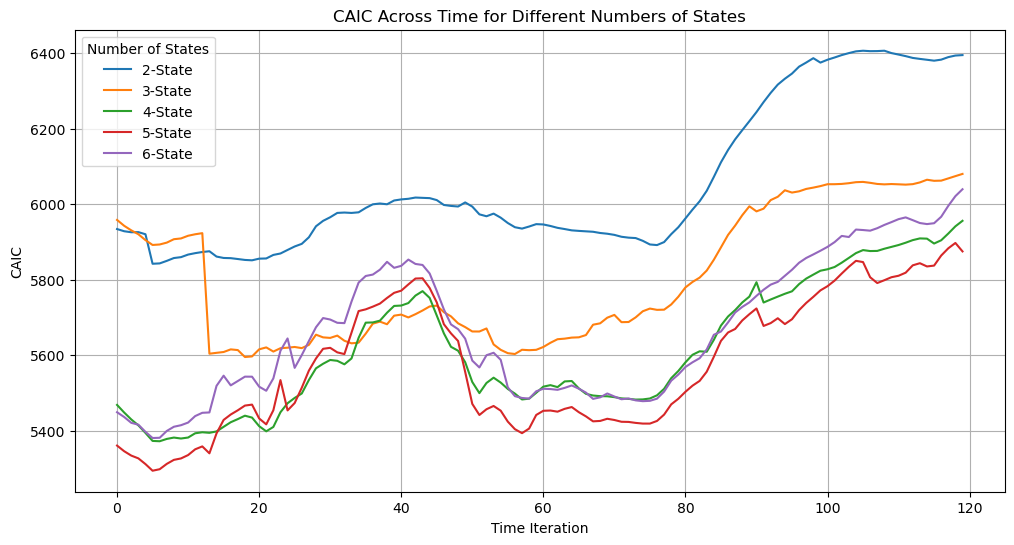

In [63]:
#Plot AIC values for different numbers of components
plt.figure(figsize=(12, 6))
for i in range(0, 5):
    plt.plot(AIC[i], label=f"{i+2}-State")
plt.title("AIC Across Time for Different Numbers of States")
plt.ylabel("AIC")
plt.xlabel("Time Iteration")
plt.grid(True)
plt.legend(title="Number of States")
plt.savefig("AIC_plot.png", format='png', dpi=300)  # Save as PNG
plt.show()

#Plot BIC 
plt.figure(figsize=(12, 6))
for i in range(0, 5):
    plt.plot(BIC[i], label=f"{i+2}-State")
plt.title("BIC Across Time for Different Numbers of States")
plt.xlabel("Time Iteration")
plt.ylabel("BIC")
plt.grid(True)
plt.legend(title="Number of States")
plt.savefig("BIC_plot.png", format='png', dpi=300)  
plt.show()

#Plot HQC 
plt.figure(figsize=(12, 6))
for i in range(0, 5):
    plt.plot(HQC[i], label=f"{i+2}-State")
plt.title("HQC Across Time for Different Numbers of States")
plt.xlabel("Time Iteration")
plt.ylabel("HQC")
plt.grid(True)
plt.legend(title="Number of States")
plt.savefig("HQC_plot.png", format='png', dpi=300) 
plt.show()

#Plot CAIC 
plt.figure(figsize=(12, 6))
for i in range(0, 5):
    plt.plot(CAIC[i], label=f"{i+2}-State")
plt.title("CAIC Across Time for Different Numbers of States")
plt.xlabel("Time Iteration")
plt.ylabel("CAIC")
plt.grid(True)
plt.legend(title="Number of States")
plt.savefig("CAIC_plot.png", format='png', dpi=300)  
plt.show()

In [65]:
#Method 2 : algoritmic choice 
#we are using the same obs as before
state_range = range(2, 7) 
best_model = None
best_criteria = {"AIC": float('inf'), "BIC": float('inf'), "HQC": float('inf'), "CAIC": float('inf')}
data_length = len(sample)
T=120

def calculate_model_criteria(hmm_model, M, k):                  #M as number of observations, k as number of parameters 
    L = hmm_model.score(sample)                                    #Use the correct model passed as the argument
    aic = -2 * L + 2 * k
    bic = -2 * L + k * np.log(M)
    hqc = -2 * L + 2 * k * np.log(np.log(M))
    caic = -2 * L + k * (1 + np.log(M))
    return {"AIC": aic, "BIC": bic, "HQC": hqc, "CAIC": caic}
 
for num_states in state_range:
    model = GaussianHMM(n_components=num_states, covariance_type='diag', random_state=42)
    model.fit(sample)

    # Number of parameters: Transition, emission, and initial probabilities
    num_params = num_states ** 2 + 2 * num_states - 1
    
    # Calculate evaluation criteria
    criteria = calculate_model_criteria(model, data_length, num_params)
    
    # Update best model based on BIC as the primary criterion
    if criteria["BIC"] < best_criteria["BIC"]:
        best_model = model
        best_criteria = criteria

print("Best Model Criteria:", best_criteria)
print(num_params)
print(num_states)

Best Model Criteria: {'AIC': 11454.34528895134, 'BIC': 11534.399984188205, 'HQC': 11486.601486508, 'CAIC': 11557.399984188205}
47
6


# Prediction using HMM

T=  240
HMM Prices: 
[89.62999725341797, 81.5199966430664, 86.489990234375, 76.42000579833984, 77.20000457763672, 82.5300064086914, 78.739990234375, 87.7699966430664, 79.41999816894531, 92.1500015258789, 95.87999725341797, 96.75, 100.30999755859375, 103.94999694824219, 108.2699966430664, 100.55999755859375, 97.7699966430664, 99.02999877929688, 99.72000122070312, 97.64999389648438, 93.98999786376953, 93.74999237060547, 103.94000244140625, 106.56999969482422, 107.19999694824219, 107.66999816894531, 109.52999877929688, 107.13999938964844, 107.38999938964844, 111.08999633789062, 110.55000305175781, 114.25, 116.66999816894531, 118.05000305175781, 116.02999877929688, 111.68000030517578, 111.5199966430664, 106.97000122070312, 104.94999694824219, 104.26000213623047, 102.23999786376953, 104.25, 108.43000030517578, 112.61000061035156, 95.95999908447266, 97.55000305175781, 96.56999969482422, 96.22000122070312, 93.9800033569336, 90.30999755859375, 87.27999877929688, 86.0, 84.72000122070312, 72.150

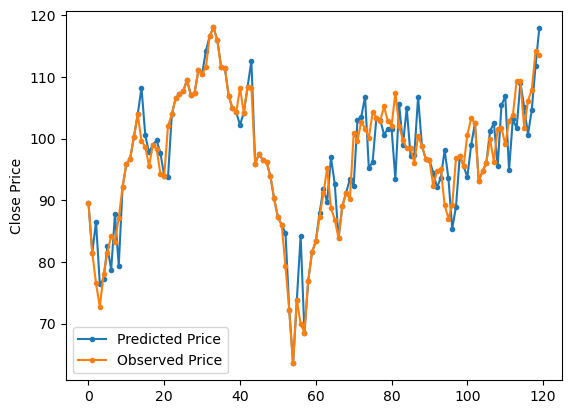

In [69]:
# Calculate number of rows and set training window
T = sample.shape[0]
print("T= ", T)

# Define the size of the training window
d = 120
D = 120
hmm_price = []

temp_T = T
first_time = True

# Sliding window approach to predict future prices
while T < temp_T + d:

    # Train HMM on data from T-D+1 to T
    train_data = monthly.iloc[T-D:T]
    train_data = train_data.dropna()

    # Set the random seed
    np.random.seed(42)

    if(first_time):
      first_time = False
      model = hmm.GaussianHMM(n_components=5)
    else:
      old_model= model
      model = hmm.GaussianHMM(n_components=5, init_params="c")
      model.startprob_ = old_model.startprob_
      model.transmat_ = old_model.transmat_
      model.means_ = old_model.means_

    model.fit(train_data)

    # Calculate original likelihood
    original_likelihood = model.score(train_data)

    # Loop to find new likelihood
    t=T
    min_diff = float('inf')
    min_t = T
    min_likelihood = original_likelihood
    while t-D>  0:
        t = t-1

        train_data = monthly.iloc[t-D:t]
        new_likelihood = model.score(train_data)
        if (abs(new_likelihood - original_likelihood))< min_diff:  # Threshold for comparison by choosing that new_likelihood which is minimum
            min_diff = abs(new_likelihood - original_likelihood)
            min_t = t
            min_likelihood = new_likelihood

    # Calculate the predicted close price
    close_price = monthly['Close'][T-1] + ((monthly['Close'][min_t + 1] - monthly['Close'][min_t]) * np.sign(original_likelihood - min_likelihood))

    hmm_price.append(close_price)
    T=T+1

# Print the calculated prices
print("HMM Prices: ")
print(hmm_price)

# Plot the predicted and observed prices
close = []
truncated_obs = monthly.iloc[T-d:T]

for i in truncated_obs['Close']:
  close.append(i)

plt.plot(hmm_price,marker='.', label = "Predicted Price")
plt.plot(close,marker = '.', label= "Observed Price")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Performance Evaluation

In [34]:
# do R2, RMSE, and confusion matrix?

In [36]:
# HMM vs HAR Returns (Out_of_sample R^2 based on stock Returns) R^2_OSR
m = d // 2

# Calculating the monthly return of closing price
close_return = [(close[i] - close[i-1]) / close[i-1] if i> 0 else 0 for i in range(d)]

#The real stock returns at each time step.
real_return=[(close[i] - close[i-1]) / close[i-1] for i in range(m+1, d)]

#The relative stock return based on the HMM model.
pred_return = [(hmm_price[i]-close[i-1])/close[i-1] for i in range(m+1,d)]

#The predicted stock returns based on the historical average return method.
har_return = [np.mean(close_return[:i]) for i in range(m+1,d)]
# har_return = [(np.mean(close[:i]) - close[i-1])/close[i-1] for i in range(m+1,D)]

# Calculate the squared errors between real return and predicted returns
squared_error_hmm_r = np.square( np.array(real_return) - np.array(pred_return))
squared_error_har_r = np.square(np.array(real_return) - np.array(har_return))

# Calculate the out-of-sample R2 for stock return based on predicted retur (R2_OSR)
r2_osr = 1 - np.sum(squared_error_hmm_r)/np.sum(squared_error_har_r)

print(r2_osr, 1 - np.sum(squared_error_hmm_r), 1 - np.sum(squared_error_har_r))


-0.8012913945955533 0.8317484797058645 0.9065939465436056


In [38]:
# HMM vs HAR Price (Out_of_sample R^2 based on stock Price) R^2_OSP
m = D // 2

#The real stock prices at each time step.
real_price=[close[i] for i in range(m+1,D)]

#The predicted stock prices based on the HMM model.
pred_price = [hmm_price[i] for i in range(m+1,D)]

#The predicted stock prices based on the historical average return method.
har_return_new = [np.mean(close_return[:i]) if i > 0 else 0 for i in range(D)]
har_price = [close[i-1]*(har_return_new[i]+1) for i in range(m+1,D)]

# Calculate the squared errors between real price and predicted price
squared_error_hmm = np.square(np.array(real_price) - np.array(pred_price))
squared_error_har = np.square(np.array(real_price) - np.array(har_price))

# Calculate the out-of-sample R2 for stock price based on predicted price (R2_OSP)
r2_osp = 1 - np.sum(squared_error_hmm)/np.sum(squared_error_har)

print(r2_osp)

-0.7996016089014941


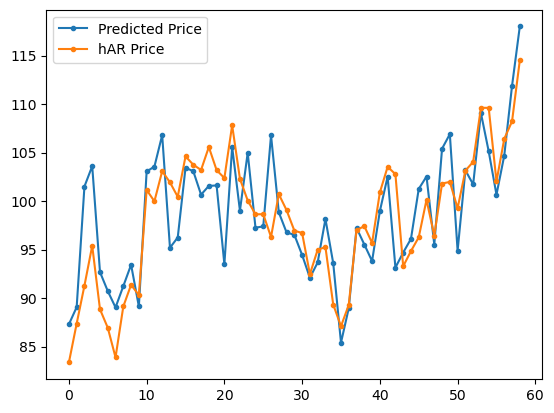

In [40]:
plt.plot(pred_price,marker='.', label = "Predicted Price")
# plt.plot(real_price,marker = '.', label= "Observed Price")
plt.plot(har_price,marker = '.', label= "hAR Price")
plt.legend()
plt.show()

In [112]:
# RMSE Error Estimate
N = m-2
def rmse(real_, pred_):
  sum = 0
  for i in range(1,N):
    sum += (np.square(real_[i] - pred_[i]))
  RMSE = np.sqrt(sum/N)
  return RMSE

rmse_hmm_price = rmse(real_price, pred_price)
rmse_har_price = rmse(real_price, har_price)
rmse_hmm_return = rmse(real_return, pred_return)
rmse_har_return = rmse(real_return, har_return)
rmse_eff_price = 1 - rmse_hmm_price/rmse_har_price
rmse_eff_return = 1 - rmse_hmm_return/rmse_har_return
print("rmse_hmm_price=",rmse_hmm_price) 
print("rmse_har_price=",rmse_har_price) 
print("rmse_eff_price=",rmse_eff_price)
print("rmse_hmm_return=",rmse_hmm_return)
print("rmse_har_return=", rmse_har_return)
print("rmse_eff_return=",rmse_eff_return)

rmse_hmm_price= 5.167768860145423
rmse_har_price= 3.839506353349251
rmse_eff_price= -0.34594616717784876
rmse_hmm_return= 0.05362699638183442
rmse_har_return= 0.03963693189708305
rmse_eff_return= -0.35295528223719375


In [ ]:
# Step 8: Trading simulation (buy if predicted rise, sell otherwise) uhhhh
data['Signal'] = np.where(data['Predicted'] > obs, 1, -1)
data['Return'] = data['Signal'] * obs.pct_change()

hmm_cumulative_return = (1 + data['Return']).cumprod()
buy_and_hold_return = (1 + obs.pct_change()).cumprod()

# Print results
print(f"HMM Cumulative Return: {hmm_cumulative_return.iloc[-1]:.2f}")
print(f"Buy-and-Hold Cumulative Return: {buy_and_hold_return.iloc[-1]:.2f}")

## failed tries idk